In [1]:
import numpy as np
import math
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
MAX_BIKES = 20          # maximum bikes at each location
MAX_MOVE = 5            # max bikes moved overnight (absolute)
RENT_REWARD = 10        # reward per fulfilled rental (INR)
MOVE_COST = 2           # cost per bike moved beyond free allowance (INR)
FREE_FROM_1_TO_2 = 1    # first bike moved from loc1->loc2 is free
PARKING_LIMIT = 10      # bikes allowed w/o extra parking
PARKING_COST = 4        # flat cost if parking limit exceeded (per location)
GAMMA = 0.9             # discount factor

In [3]:
# Poisson parameters (rental requests and returns)
req_lambda = [3, 4]   # expected rental requests at loc1, loc2
ret_lambda = [3, 2]   # expected returns at loc1, loc2

# Poisson truncation (we aggregate >= POISSON_UPPER into one bucket)
POISSON_UPPER = 11

In [4]:
# -----------------------
# Poisson pmf caching
# -----------------------
poisson_cache = {}
def truncated_poisson_pmf(lam):
    # returns list of length POISSON_UPPER+1, last item is tail probability for >= POISSON_UPPER
    if lam in poisson_cache:
        return poisson_cache[lam]
    probs = [poisson.pmf(i, lam) for i in range(POISSON_UPPER)]
    tail = 1.0 - sum(probs)
    probs.append(tail)
    poisson_cache[lam] = probs
    return probs

req_pmf_0 = truncated_poisson_pmf(req_lambda[0])
req_pmf_1 = truncated_poisson_pmf(req_lambda[1])
ret_pmf_0 = truncated_poisson_pmf(ret_lambda[0])
ret_pmf_1 = truncated_poisson_pmf(ret_lambda[1])

# convenience to interpret index (last index means >= POISSON_UPPER)
def actual_count(idx):
    if idx < POISSON_UPPER:
        return idx
    else:
        return POISSON_UPPER  # represents ">= POISSON_UPPER"

# iterate all combos of demand/return with their joint probability
def iterate_demands_returns():
    upper = POISSON_UPPER
    for r0 in range(upper+1):
        p_r0 = req_pmf_0[r0]
        if p_r0 == 0: continue
        for r1 in range(upper+1):
            p_r1 = req_pmf_1[r1]
            if p_r1 == 0: continue
            for ret0 in range(upper+1):
                p_ret0 = ret_pmf_0[ret0]
                if p_ret0 == 0: continue
                for ret1 in range(upper+1):
                    p_ret1 = ret_pmf_1[ret1]
                    if p_ret1 == 0: continue
                    prob = p_r0 * p_r1 * p_ret0 * p_ret1
                    yield (r0, r1, ret0, ret1, prob)


In [5]:
# -----------------------
# States and actions
# -----------------------
states = [(i, j) for i in range(MAX_BIKES+1) for j in range(MAX_BIKES+1)]
num_states = len(states)
actions = np.arange(-MAX_MOVE, MAX_MOVE+1)  # negative: move from loc2->loc1; positive: loc1->loc2

state_to_index = {s: idx for idx, s in enumerate(states)}
index_to_state = {idx: s for s, idx in state_to_index.items()}

In [6]:
# -----------------------
# Precompute transitions: P[(state_idx, action)] -> list of (prob, next_state_idx, expected_reward)
# -----------------------
print("Precomputing transition probabilities and expected immediate rewards... (this may take a while)")
start_time = time.time()
P = {}
for s_idx, (n1, n2) in enumerate(states):
    for a in actions:
        moved = a
        n1_after = n1 - moved   # after moving (before rentals)
        n2_after = n2 + moved
        # feasibility check
        if (n1_after < 0) or (n1_after > MAX_BIKES) or (n2_after < 0) or (n2_after > MAX_BIKES):
            P[(s_idx, a)] = []
            continue
        # move cost with free first bike if moving from loc1 -> loc2
        if moved > 0:
            move_cost = MOVE_COST * max(0, moved - FREE_FROM_1_TO_2)
        else:
            move_cost = MOVE_COST * abs(moved)
        # parking penalty after moving (flat per location if > limit)
        parking_charge = 0
        if n1_after > PARKING_LIMIT:
            parking_charge += PARKING_COST
        if n2_after > PARKING_LIMIT:
            parking_charge += PARKING_COST
        immediate_move_and_parking = - (move_cost + parking_charge)

        transitions = {}  # map next_state_idx -> [prob_sum, reward_sum]
        for req0_idx, req1_idx, ret0_idx, ret1_idx, prob in iterate_demands_returns():
            if prob == 0:
                continue
            d0 = actual_count(req0_idx)
            d1 = actual_count(req1_idx)
            r0 = actual_count(ret0_idx)
            r1 = actual_count(ret1_idx)
            rentals0 = min(n1_after, d0)
            rentals1 = min(n2_after, d1)
            reward_from_rentals = RENT_REWARD * (rentals0 + rentals1)
            n1_endday = n1_after - rentals0
            n2_endday = n2_after - rentals1
            n1_next = min(n1_endday + r0, MAX_BIKES)
            n2_next = min(n2_endday + r1, MAX_BIKES)
            next_idx = state_to_index[(n1_next, n2_next)]
            total_reward = immediate_move_and_parking + reward_from_rentals
            if next_idx not in transitions:
                transitions[next_idx] = [0.0, 0.0]
            transitions[next_idx][0] += prob
            transitions[next_idx][1] += prob * total_reward

        trans_list = []
        for next_idx, (p_sum, rew_sum) in transitions.items():
            if p_sum > 0:
                expected_reward = rew_sum / p_sum
                trans_list.append((p_sum, next_idx, expected_reward))
        P[(s_idx, a)] = trans_list

end_time = time.time()
print(f"Precomputation done in {end_time - start_time:.1f}s. States: {num_states}")


Precomputing transition probabilities and expected immediate rewards... (this may take a while)
Precomputation done in 577.3s. States: 441


Starting policy iteration ...
Iteration 1: policy eval iters = 75, stable = False
Iteration 2: policy eval iters = 66, stable = False
Iteration 3: policy eval iters = 46, stable = False
Iteration 4: policy eval iters = 13, stable = True
Policy iteration completed in 4 iterations.

Sample of optimal policy (rows = n1, cols = n2):
[[ 0  0  0  0  0  0  0 -1 -1 -2 -2 -3 -3 -3 -4 -5 -4 -4 -5 -5 -5]
 [ 1  0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -4 -5 -3 -4 -4 -4 -4]
 [ 1  1  0  0  0  0  0  0  0 -1 -1 -1 -2 -3 -4 -5 -3 -3 -3 -3 -3]
 [ 1  1  1  1  0  0  0  0  0  0  0 -1 -2 -3 -4 -5 -2 -2 -2 -2 -2]
 [ 1  1  1  1  1  0  0  0  0  0  0 -1 -2 -3 -4 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1  0  0  0  0  0 -1 -2 -3  0  0  0  0  0  0 -1]
 [ 2  1  1  1  1  1  1  1  0  0  0 -1 -2  0  0  0  0  0  0  0  0]
 [ 2  2  1  1  1  1  1  1  1  0  0 -1 -2  0  0  0  0  0  0  0  0]
 [ 3  2  2  1  1  1  1  1  1  1  0 -1  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  1  1  1  1  1  0 -1  0  0  0  0  0  0  0  0  0]
 [ 4  3  

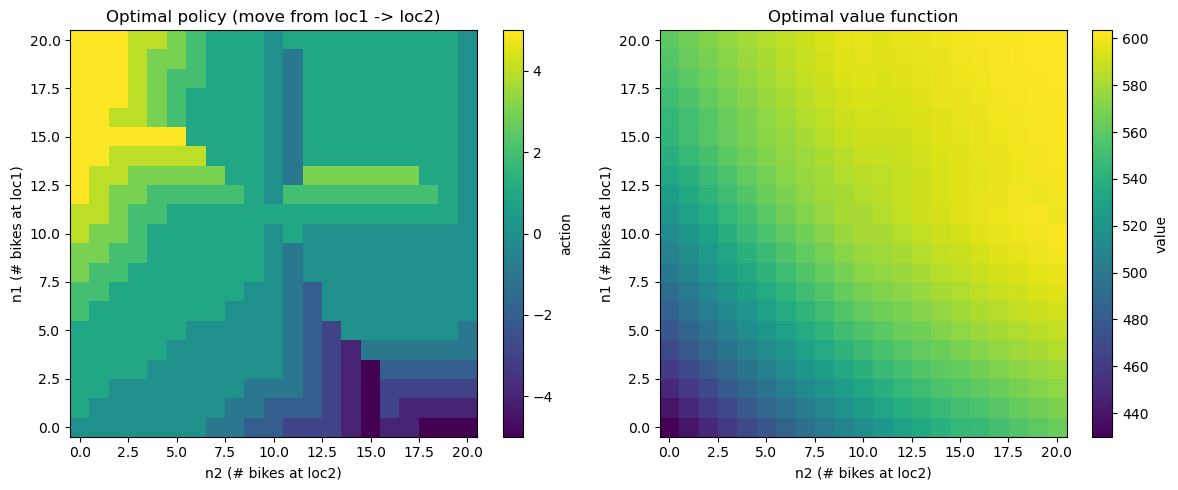

Policy and value saved to gbike_policy.csv and gbike_value.csv


In [7]:
# -----------------------
# Policy iteration
# -----------------------
policy = np.zeros(num_states, dtype=int)
# ensure initial policy is feasible
for s_idx in range(num_states):
    feas = [a for a in actions if P[(s_idx,a)]]
    policy[s_idx] = feas[0] if feas else 0

V = np.zeros(num_states)
THETA = 1e-4

def policy_evaluation(policy, V, theta=THETA):
    it = 0
    while True:
        delta = 0.0
        for s_idx in range(num_states):
            a = policy[s_idx]
            trans_list = P[(s_idx, a)]
            if not trans_list:
                v_new = -1e6
            else:
                v_new = sum(prob * (exp_reward + GAMMA * V[next_idx])
                            for (prob, next_idx, exp_reward) in trans_list)
            delta = max(delta, abs(V[s_idx] - v_new))
            V[s_idx] = v_new
        it += 1
        if delta < theta:
            break
    return V, it

def policy_improvement(policy, V):
    policy_stable = True
    new_policy = policy.copy()
    for s_idx in range(num_states):
        old_action = policy[s_idx]
        action_values = {}
        for a in actions:
            trans_list = P[(s_idx,a)]
            if not trans_list:
                continue
            q = sum(prob * (exp_reward + GAMMA * V[next_idx]) for (prob, next_idx, exp_reward) in trans_list)
            action_values[a] = q
        if not action_values:
            continue
        # choose best action (tie-breaker can prefer smaller moves)
        best_action = max(action_values.items(), key=lambda x: (x[1], -abs(x[0])))[0]
        new_policy[s_idx] = best_action
        if best_action != old_action:
            policy_stable = False
    return policy_stable, new_policy

# iterate
print("Starting policy iteration ...")
iterations = 0
while True:
    iterations += 1
    V, eval_iters = policy_evaluation(policy, V)
    stable, new_policy = policy_improvement(policy, V)
    print(f"Iteration {iterations}: policy eval iters = {eval_iters}, stable = {stable}")
    policy = new_policy
    if stable or iterations >= 50:
        break

print(f"Policy iteration completed in {iterations} iterations.")

# reshape outputs for display
policy_grid = np.zeros((MAX_BIKES+1, MAX_BIKES+1), dtype=int)
value_grid = np.zeros((MAX_BIKES+1, MAX_BIKES+1))
for s_idx, (n1, n2) in enumerate(states):
    policy_grid[n1, n2] = policy[s_idx]
    value_grid[n1, n2] = V[s_idx]

print("\nSample of optimal policy (rows = n1, cols = n2):")
print(policy_grid)

print("\nValue function sample (rounded):")
with np.printoptions(precision=1, suppress=True):
    print(value_grid)

# Plot policy and value heatmaps
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Optimal policy (move from loc1 -> loc2)")
plt.imshow(policy_grid, origin='lower', aspect='auto')
plt.xlabel('n2 (# bikes at loc2)')
plt.ylabel('n1 (# bikes at loc1)')
plt.colorbar(label='action')

plt.subplot(1,2,2)
plt.title("Optimal value function")
plt.imshow(value_grid, origin='lower', aspect='auto')
plt.xlabel('n2 (# bikes at loc2)')
plt.ylabel('n1 (# bikes at loc1)')
plt.colorbar(label='value')
plt.tight_layout()
plt.show()

# Save outputs to CSV in working directory (uncomment if you need saved files)
pd.DataFrame(policy_grid).to_csv('gbike_policy.csv', index=False)
pd.DataFrame(value_grid).to_csv('gbike_value.csv', index=False)
print("Policy and value saved to gbike_policy.csv and gbike_value.csv")